### ANOVA на практике

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#грузим первые данные

post_likes = pd.read_csv("post_likes.csv")

In [4]:
post_likes

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187
...,...,...,...
295,S296,blue,196
296,S297,blue,252
297,S298,blue,194
298,S299,blue,185


Порисуем графички:

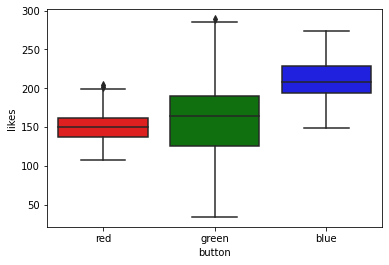

In [7]:
#боксплот

sns.boxplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

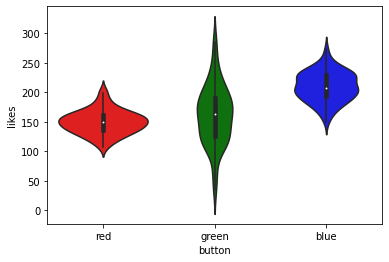

In [8]:
#скрипичный график

sns.violinplot(x="button", y="likes", data=post_likes, palette=["r", "g", "b"])

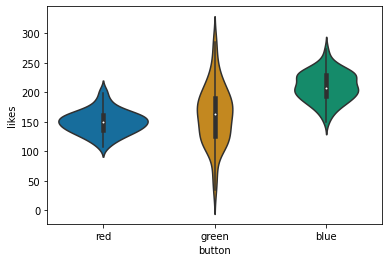

In [9]:
#для студентов с цветовой слепотой

sns.violinplot(x="button", y="likes", data=post_likes, palette="colorblind")

Три способа посчитать однофакторный ANOVA:

In [10]:
#через scipy
# однофакторный - f_oneway

red = post_likes.query("button == 'red'").likes
green = post_likes.query("button == 'green'").likes
blue = post_likes.query("button == 'blue'").likes

In [13]:
post_likes.query("button == 'red'").likes

0     160
1     150
2     150
3     150
4     187
     ... 
95    170
96    164
97    125
98    152
99    126
Name: likes, Length: 100, dtype: int64

In [14]:
ss.f_oneway(red, green, blue)

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

In [17]:
#через statsmodels

model = smf.ols(formula = "likes ~ C(button)", data = post_likes).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(button),2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [19]:
348748.710000 / 297.0

1174.238080808081

In [19]:
100980.143333/1174.238081

85.99631111180085

In [21]:
#через pingouin

pg.anova(data=post_likes, dv="likes", between="button",detailed = True)

,Source,SS,DF,MS,F,p-unc,np2
0,button,201960.286667,2,100980.143333,85.996311,3.437005e-30,0.366728
1,Within,348748.710000,297,1174.238081,NaN,NaN,NaN


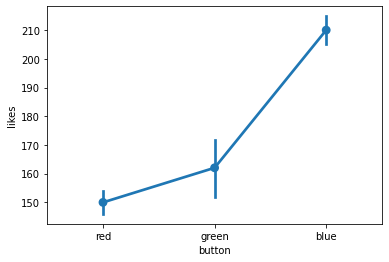

In [22]:
#средние с доверительными интервалами

sns.pointplot(x="button", y="likes", data=post_likes)

Тестируем нормальность:

In [24]:
#через scipy 

print(ss.shapiro(red))
print(ss.shapiro(blue))
print(ss.shapiro(green))

# значимо от нормлаьных не отличаются так как p-value больше 0.05

ShapiroResult(statistic=0.988104522228241, pvalue=0.515945315361023)
ShapiroResult(statistic=0.9937936663627625, pvalue=0.9309920072555542)
ShapiroResult(statistic=0.9887180328369141, pvalue=0.5625539422035217)


In [25]:
#другой вариант

print(ss.normaltest(red))
print(ss.normaltest(blue))
print(ss.normaltest(green))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)


In [26]:
#через pingouin

pg.normality(data=post_likes, dv="likes", group="button", method="normaltest")

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


Можно квантиль-квантиль графики:

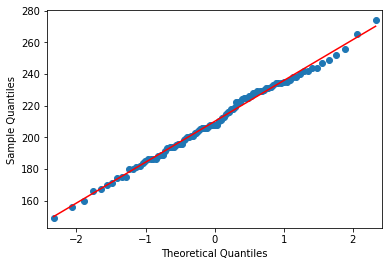

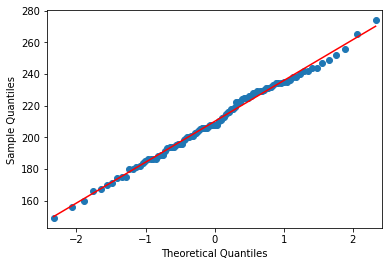

In [27]:
sm.qqplot(blue, line="r")

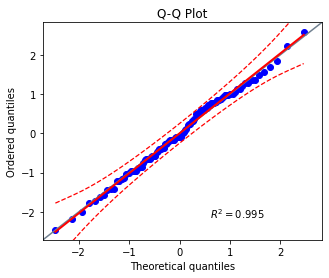

In [28]:
pg.qqplot(blue)

Тестируем различие в дисперсиях:

In [29]:
#через scipy

ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [30]:
#через pingouin

pg.homoscedasticity(data=post_likes, dv="likes", group="button")

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


In [31]:
#anova Уэлча в pingouin

pg.welch_anova(data=post_likes, dv="likes", between="button")

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


#### Множественные сравнения

In [32]:
from scipy.special import comb

In [57]:
comb(5, 2)

10.0

In [34]:
1 - 0.95**45

0.9005597430129078

In [58]:
0.05/3

0.016666666666666666

In [35]:
#попарные сравнения без поправки
pg.pairwise_ttests(data=post_likes, dv="likes", between="button")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [36]:
2.619001e-02

0.02619001

In [41]:
#с поправкой Бонферрони
pg.pairwise_ttests(data=post_likes, dv="likes", between="button", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,7.685599e-15,bonf,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,bonf,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,7.857004e-02,bonf,1.583,0.315609


In [42]:
7.857004e-02

0.07857004

In [43]:
#тьюки

pg.pairwise_tukey(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [44]:
#геймс-хоувелл  учитывает разные дисперсии

pg.pairwise_gameshowell(data=post_likes, dv="likes", between="button")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [45]:
pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [46]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


#### Многофакторный ANOVA

In [47]:
#грузим многофакторные данные

ads_clicks = pd.read_csv("ads_clicks.csv")

In [49]:
ads_clicks

,id,ads,age_group,clicks
0,S001,classic,18-27,40
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
...,...,...,...,...
595,S596,bold,46 and more,3
596,S597,bold,46 and more,5
597,S598,bold,46 and more,6
598,S599,bold,46 and more,5


In [50]:
#через statsmodels, только главные эффекты

model_main = smf.ols("clicks ~ C(ads) + C(age_group)", data=ads_clicks).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,68.810244,7.245176e-16
C(age_group),2.0,400495.163333,200247.581667,408.450696,1.950084e-112
Residual,596.0,292195.753333,490.261331,NaN,NaN


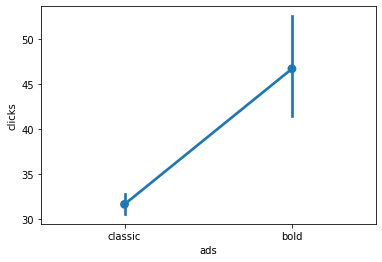

In [51]:
#первый фактор

sns.pointplot(x="ads", y="clicks", data=ads_clicks)

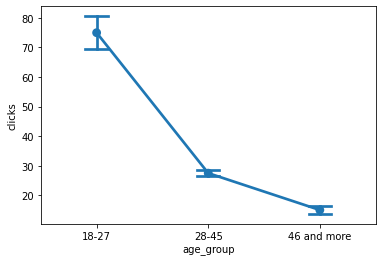

In [52]:
#второй фактор

sns.pointplot(x="age_group", y="clicks", data=ads_clicks, capsize=0.2)

In [53]:
#взаимодействие

model_interact = smf.ols("clicks ~ C(ads)*C(age_group)", data=ads_clicks).fit()
anova_lm(model_interact)

,df,sum_sq,mean_sq,F,PR(>F)
C(ads),1.0,33735.001667,33735.001667,336.722432,6.446773e-60
C(age_group),2.0,400495.163333,200247.581667,1998.750536,1.636934e-264
C(ads):C(age_group),2.0,232685.043333,116342.521667,1161.260853,5.618312e-206
Residual,594.0,59510.710000,100.186380,NaN,NaN


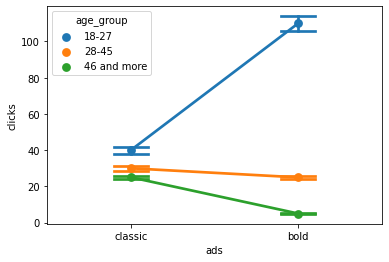

In [57]:
#взаимодействие

sns.pointplot(x="ads", y="clicks", hue="age_group", data=ads_clicks, capsize=0.2)

In [54]:
#теперь pingouin

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"])

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [55]:
#размер эффекта

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.046440
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.551323
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.320315
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [56]:
#тип суммы квадратов

pg.anova(data=ads_clicks, dv="clicks", between=["ads", "age_group"], ss_type=2)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33735.001667,1,33735.001667,336.722432,6.446773e-60,0.361786
1,age_group,400495.163333,2,200247.581667,1998.750536,1.636934e-264,0.870631
2,ads * age_group,232685.043333,2,116342.521667,1161.260853,5.618312e-206,0.796333
3,Residual,59510.710000,594,100.186380,NaN,NaN,NaN


In [63]:
dat_unbalanced = ads_clicks.query("id != 'S001'")

In [64]:
dat_unbalanced.head()

,id,ads,age_group,clicks
1,S002,classic,18-27,22
2,S003,classic,18-27,41
3,S004,classic,18-27,35
4,S005,classic,18-27,39
5,S006,classic,18-27,35


In [65]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["ads", "age_group"], ss_type=1)

,Source,SS,DF,MS,F,p-unc,np2
0,ads,33803.779316,1.0,33803.779316,336.840901,6.486330e-60,0.362256
1,age_group,401187.127208,2.0,200593.563604,1998.833209,2.914479e-264,0.870825
2,ads * age_group,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN


In [70]:
pg.anova(data=dat_unbalanced, dv="clicks", between=["age_group", "ads"], ss_type=3)

,Source,SS,DF,MS,F,p-unc,np2
0,age_group,399202.638264,2.0,199601.319132,1988.945896,1.048185e-263,0.870266
1,ads,33678.455412,1.0,33678.455412,335.592099,9.673077e-60,0.361399
2,age_group * ads,231923.625646,2.0,115961.812823,1155.512262,2.698570e-205,0.795801
3,Residual,59510.709899,593.0,100.355329,NaN,NaN,NaN
